### Ноут для экспериментов с подходом Adaptive Critic на основе задачи управления перевернутым маятником

##### Система уравнений перевернутого маятника с трением
$\ddot{\varphi}+f\dot{\varphi}-\sin{\varphi}=M$

$\begin{cases} \dot{\varphi}=\psi \\ \dot{\psi}=-f\psi+\sin{\varphi}+M \end{cases}$

##### Состояния равновесия
$\psi = 0, \quad \varphi=0,\pi$

##### Линеаризация 
$\begin{bmatrix} 0 & 1 \\ \cos{\varphi} & -f \\\end{bmatrix}$

Для состояния $(0, 0)$:
$\begin{bmatrix} -\lambda & 1 \\ 1 & -f-\lambda \\\end{bmatrix} = 0$  
$\lambda^2+f\lambda-1=0$  
$\lambda=\dfrac{-f\pm\sqrt{f^2+4}}{2}$  
оно неустойчивое

Для состояния $(\pi, 0)$:
$\begin{bmatrix} -\lambda & 1 \\ -1 & -f-\lambda \\\end{bmatrix} = 0$  
$\lambda^2+f\lambda+1=0$  
$\lambda=\dfrac{-f\pm\sqrt{f^2-4}}{2}$  
оно устойчивое

In [164]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

In [38]:
def pendulum(t, y, c):
    f = 0.106
    M = c(t, y)
    #M = -0.9266 * y[0] + 0.0159 * y[1]
    return [y[1], -f * y[1] + math.sin(y[0]) + M]

In [37]:
def control(t, y):
    return -y[0]

In [193]:
def solve_equation(c,y0 = [1.5, 0.2], n=100):
    t0, t1 = 0, 100
    ts = np.linspace(t0, t1, n)

    return integrate.solve_ivp(fun=lambda t,y: pendulum(t,y,c), t_span=[t0, t1], y0=y0, t_eval=ts, method='RK45')

In [125]:
def plot_solution(sol):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.ylabel(r'$\varphi$', fontsize=16)
    plt.xlabel(r'$t$', fontsize=16)
    plt.plot(sol.t, sol.y[0])
    plt.subplot(2, 1, 2)
    plt.ylabel(r'$\psi$', fontsize=16)
    plt.xlabel(r'$t$', fontsize=16)
    plt.plot(sol.t, sol.y[1])
    plt.show()

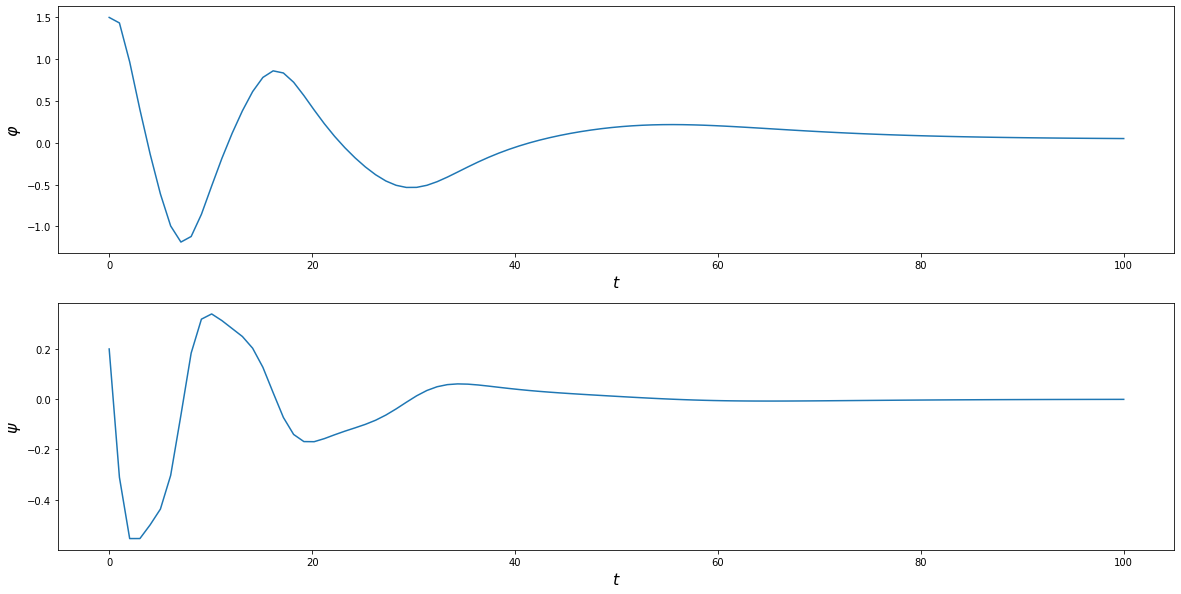

In [129]:
sol = solve_equation(control)
plot_solution(sol)

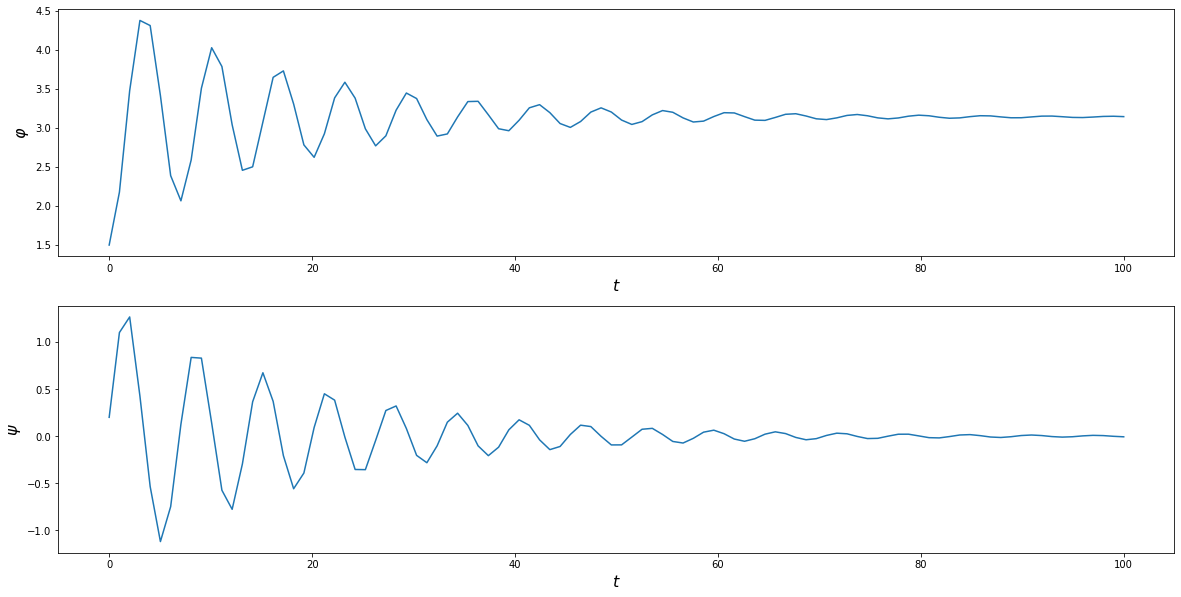

In [57]:
sol = solve_equation(lambda t,y: 0)
plot_solution(sol)

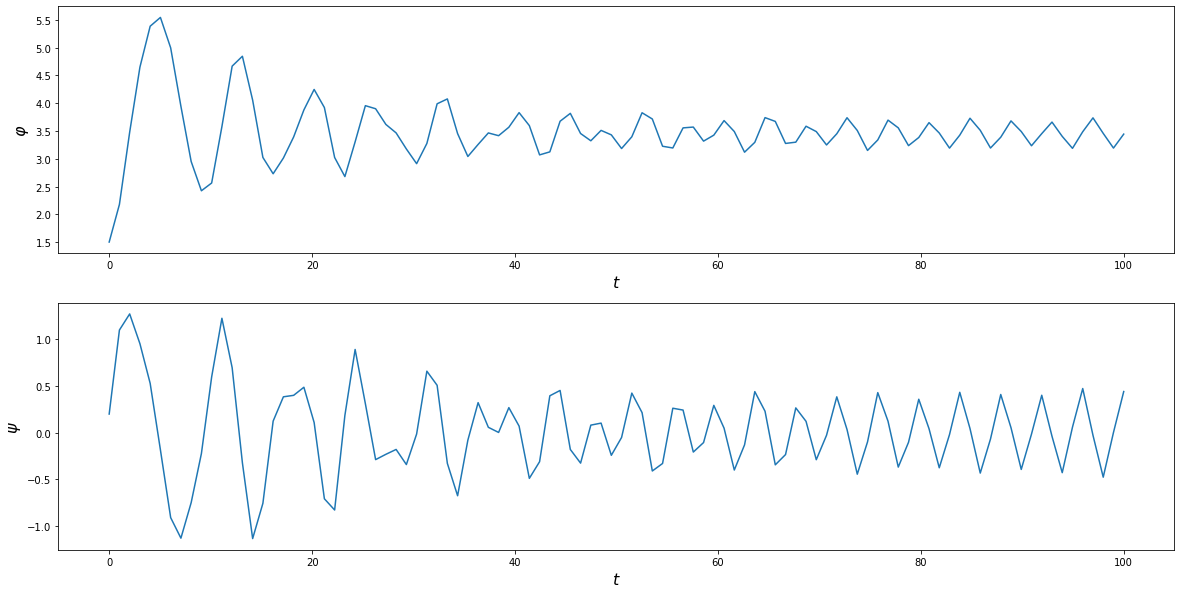

In [185]:
sol = solve_equation(lambda t,y: t // 2 % 2 * 0.6)
plot_solution(sol)

### На основе симуляции подбираем модель для индентификации системы

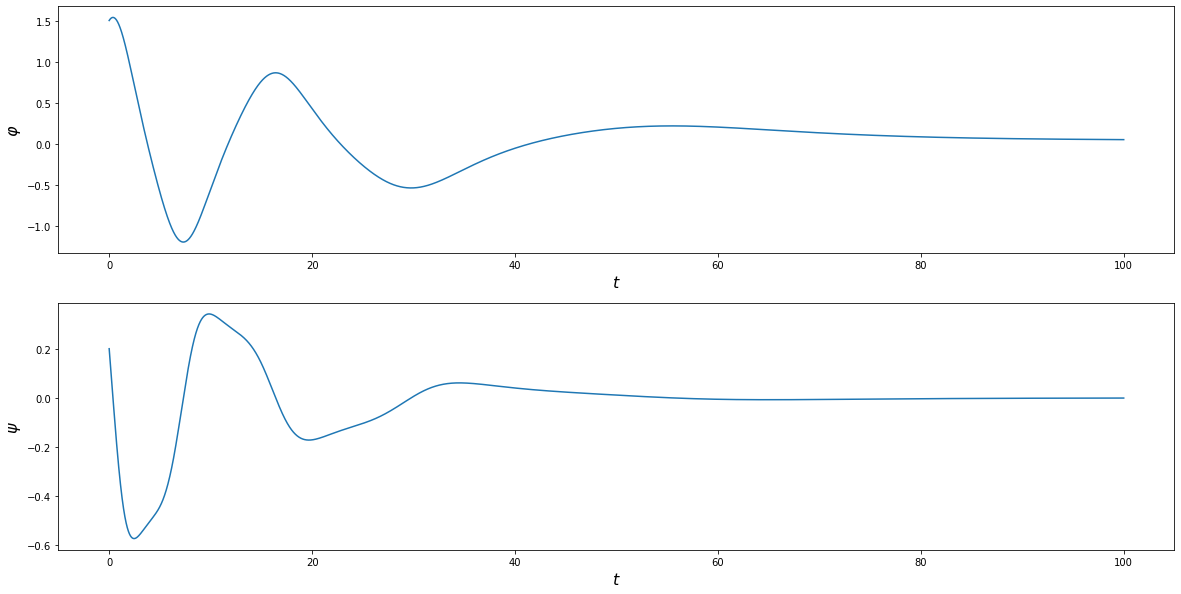

In [178]:
sol = solve_equation(control, n=100000)
plot_solution(sol)

##### Формируем фрейм по данным
t,phi,psi,c,t_next - вход  
phi_next, psi_next - выход

In [131]:
df = pd.DataFrame({'t': sol.t, 'phi': sol.y[0], 'psi': sol.y[1]})
df = df.assign(
    c = lambda x: control(x.t, [x.phi, x.psi]),
    t_next=df.t.shift(-1),
    phi_next=df.phi.shift(-1),
    psi_next=df.psi.shift(-1)
)
df = df.iloc[:-1]
df.head()

,t,phi,psi,c,t_next,phi_next,psi_next
0,0.000,1.500000,0.200000,-1.500000,0.001,1.500200,0.199476
1,0.001,1.500200,0.199476,-1.500200,0.002,1.500399,0.198952
2,0.002,1.500399,0.198952,-1.500399,0.003,1.500598,0.198428
3,0.003,1.500598,0.198428,-1.500598,0.004,1.500796,0.197904
4,0.004,1.500796,0.197904,-1.500796,0.005,1.500993,0.197380


##### Разделяем на обучающую и тестовую

In [132]:
X = df[['t','phi','psi','c','t_next']]
Y = df[['phi_next', 'psi_next']]

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

69999 30000


##### Обучаем модель регрессии на неглубокой полносвязной нейронной сети

In [167]:
# 'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (120, 80, 40), 'learning_rate': 'constant', 'max_iter': 50, 'solver': 'adam'
regr = MLPRegressor(
    random_state=42,
    max_iter=50,
    activation='tanh',
    alpha = 0.0001,
    hidden_layer_sizes=(120,),
    learning_rate='constant',
    solver='adam'
).fit(X_train, Y_train)
regr.predict(X_test)
regr.score(X_test, Y_test)

0.9950694903862232

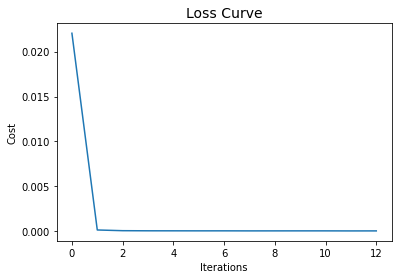

In [168]:
plt.plot(regr.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [234]:
def build_df(t,y,c,t_next):
    return [[t,y[0],y[1],c,t_next]]
# return pd.DataFrame({'t':[t],'phi':[y[0]],'psi':[y[1]],'c':[c],'t_next':[t_next]})

In [232]:
class Sol:
    
    def __init__(self, t, y):
        self.t = t
        self.y = y

def pendulum_regr(regr, y0 = [1.5, 0.2], c=control):
    t0, t1 = 0, 100
    ts = np.linspace(t0, t1, 10000)
    
    res_t = []
    res_phi = []
    res_psi = []
    
    t = ts[0]
    phi = y0[0]
    psi = y0[1]
    
    for t_next in ts[1:]:
        
        res_t.append(t)
        res_phi.append(phi)
        res_psi.append(psi)
        c = control(t,[phi,psi])
        current = build_df(t,[phi,psi],c,t_next)
        # ПРОВЕРИТЬ ТУТ
        nxt = regr.predict(current)
        t = t_next
        phi = nxt[0][0]
        psi = nxt[0][1]
        
    return Sol(res_t, [res_phi, res_psi])

In [135]:
def plot_compare(sol1, sol2):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.ylabel(r'$\varphi$', fontsize=16)
    plt.xlabel(r'$t$', fontsize=16)
    plt.plot(sol1.t, sol1.y[0], color='b', label='ode')
    plt.plot(sol2.t, sol2.y[0], color='r', label='regr')
    plt.subplot(2, 1, 2)
    plt.ylabel(r'$\psi$', fontsize=16)
    plt.xlabel(r'$t$', fontsize=16)
    plt.plot(sol1.t, sol1.y[1], color='b', label='ode')
    plt.plot(sol2.t, sol2.y[1], color='r', label='regr')
    plt.show()

##### Сравниваем траектории полученные через решение ДУ и с помощью Регрессора

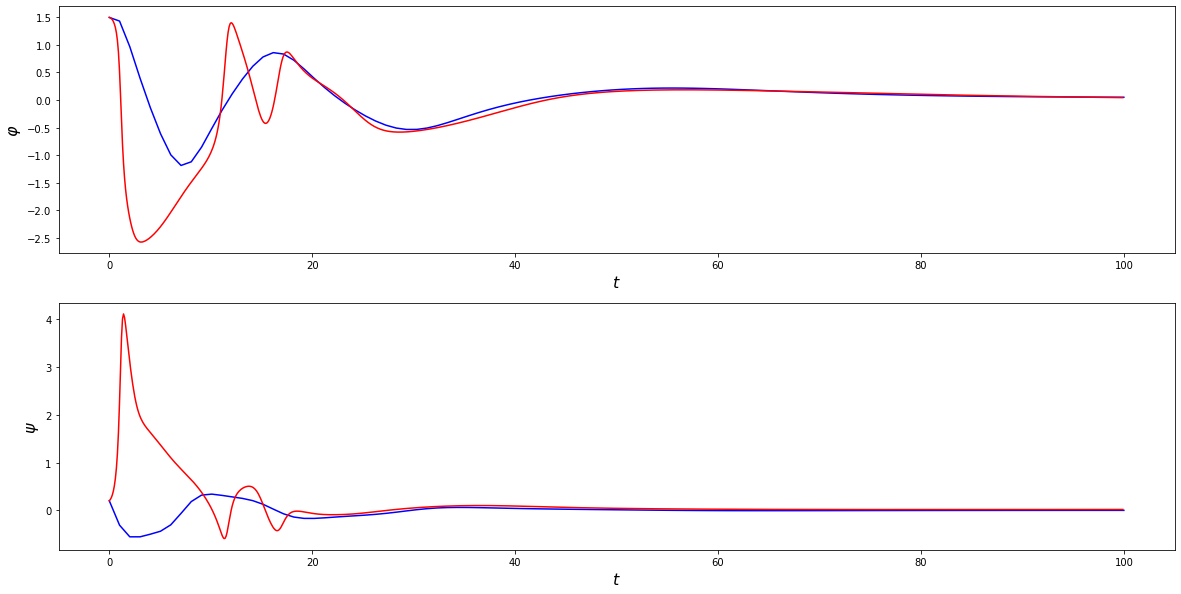

In [174]:
import warnings
warnings.filterwarnings("ignore")
sol = solve_equation(control)
sol_regr = pendulum_regr(regr)
plot_compare(sol, sol_regr)

In [177]:
df_test = pd.DataFrame({'t': sol_regr.t, 'phi': sol_regr.y[0], 'psi': sol_regr.y[1]})
df_test = df_test.assign(
    c = lambda x: control(x.t, [x.phi, x.psi])
)
df_test.head(20)

,t,phi,psi,c
0,0.000000,1.500000,0.200000,-1.500000
1,0.100100,1.493347,0.226884,-1.493347
2,0.200200,1.479774,0.266843,-1.479774
3,0.300300,1.457993,0.324113,-1.457993
4,0.400400,1.425891,0.404460,-1.425891
5,0.500501,1.380023,0.516064,-1.380023
6,0.600601,1.314665,0.670967,-1.314665
7,0.700701,1.220105,0.887403,-1.220105
8,0.800801,1.079755,1.192987,-1.079755
9,0.900901,0.866740,1.626158,-0.866740


In [171]:
df.head(9000)

,t,phi,psi,c,t_next,phi_next,psi_next
0,0.00000,1.500000,0.200000,-1.500000,0.00100,1.500200,0.199476
1,0.00100,1.500200,0.199476,-1.500200,0.00200,1.500399,0.198952
2,0.00200,1.500399,0.198952,-1.500399,0.00300,1.500598,0.198428
3,0.00300,1.500598,0.198428,-1.500598,0.00400,1.500796,0.197904
4,0.00400,1.500796,0.197904,-1.500796,0.00500,1.500993,0.197380
...,...,...,...,...,...,...,...
8995,8.99509,-0.887213,0.311705,0.887213,8.99609,-0.886901,0.311783
8996,8.99609,-0.886901,0.311783,0.886901,8.99709,-0.886589,0.311862
8997,8.99709,-0.886589,0.311862,0.886589,8.99809,-0.886276,0.311940
8998,8.99809,-0.886276,0.311940,0.886276,8.99909,-0.885964,0.312018


In [194]:
def sol_to_df(sol):
    df = pd.DataFrame({'t': sol.t, 'phi': sol.y[0], 'psi': sol.y[1]})
    df = df.assign(
    c = lambda x: control(x.t, [x.phi, x.psi]),
        t_next=df.t.shift(-1),
        phi_next=df.phi.shift(-1),
        psi_next=df.psi.shift(-1)
    )
    df = df.iloc[:-1]
    return df

##### Готовим обучающую выборку

In [218]:
all_df = []
for phi in np.linspace(-1.5, 1.5, num=20):
    for psi in np.linspace(-1, 1, num=15):
        sol = solve_equation(control, y0 = [phi, psi], n=15000)
        df = sol_to_df(sol)
        all_df.append(df)
for phi in np.linspace(-1.5, 1.5, num=15):
    for psi in np.linspace(-1, 1, num=20):
        sol = solve_equation(lambda t,y: 0, y0 = [phi, psi], n=10000)
        df = sol_to_df(sol)
        all_df.append(df)
for phi in np.linspace(-1.5, 1.5, num=20):
    for psi in np.linspace(-1, 1, num=10):
        sol = solve_equation(lambda t,y: t // 2 % 2 * 0.6, y0 = [phi, psi], n=1000)
        df = sol_to_df(sol)
        all_df.append(df)
df = pd.concat(all_df)

In [219]:
df.head()

,t,phi,psi,c,t_next,phi_next,psi_next
0,0.000000,-1.500000,-1.000000,1.500000,0.006667,-1.506654,-0.995924
1,0.006667,-1.506654,-0.995924,1.506654,0.013334,-1.513280,-0.991809
2,0.013334,-1.513280,-0.991809,1.513280,0.020001,-1.519878,-0.987656
3,0.020001,-1.519878,-0.987656,1.519878,0.026668,-1.526449,-0.983464
4,0.026668,-1.526449,-0.983464,1.526449,0.033336,-1.532992,-0.979233


In [220]:
X = df[['t','phi','psi','c','t_next']]
Y = df[['phi_next', 'psi_next']]

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

5389440 2309760


In [225]:
regr = MLPRegressor(hidden_layer_sizes=(20, 20)).fit(X_train, Y_train)
regr.predict(X_test)
regr.score(X_test, Y_test)

0.9995750809936057

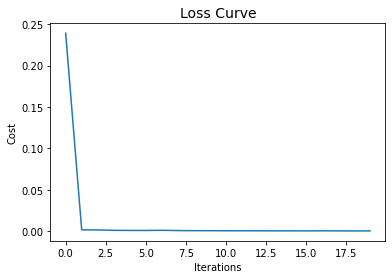

In [226]:
plt.plot(regr.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

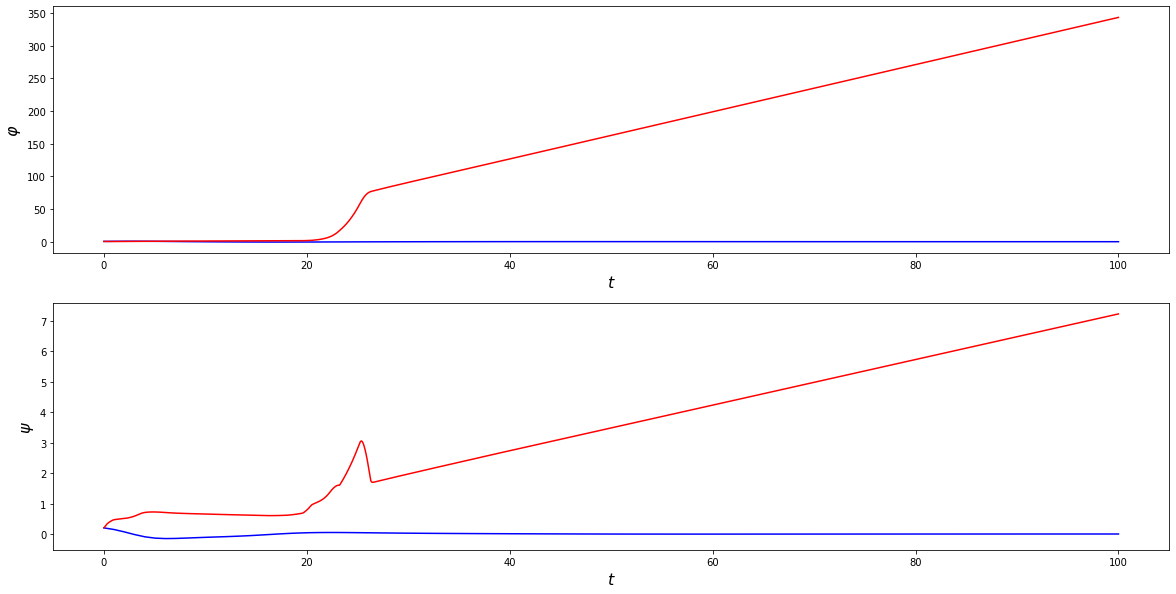

In [235]:
import warnings
warnings.filterwarnings("ignore")
sol = solve_equation(control, y0=[0.5, 0.2])
sol_regr = pendulum_regr(regr, y0=[0.5, 0.2], c = control)
plot_compare(sol, sol_regr)